## Before starting: select "dtw" kernel

- In the menu bar on top of this notebook, select Kernel > Change Kernel > "dtw"

- In the top right corner, there should be the Python logo and "dtw" should be written next to the circle monitoring kernel activity.


# (Step2) align two sequences with sm-dtw

*In step1*, you previously produced a pair of phyllotaxis sequences: one reference sequence and a test sequence which derives from the first after typical "measurement errors". Each phyllotaxis sequence is made of two sub-sequences: the divergence angles and the internode lengths between successive organs along a stem.

Here, you will use our program `sm-dtw` to realign the test sequence with the reference and detect automatically the potential additions or losses of organs along the test sequence.


## Upload simulated sequences generated in step1

In [1]:
import numpy as np
import pandas as pd

# from dtw.tasks.compare_sequences import CONSTRAINTS
# from dtw.tasks.compare_sequences import DEF_BEAMSIZE
# from dtw.tasks.compare_sequences import DEF_CONSTRAINT
# from dtw.tasks.compare_sequences import DEF_DELINS_COST
# from dtw.tasks.compare_sequences import DEF_FREE_ENDS
# from dtw.tasks.compare_sequences import DEF_FREE_ENDS_EPS
# from dtw.tasks.compare_sequences import DEF_MAX_STRETCH
# from dtw.tasks.compare_sequences import sequence_comparison
from dtw import DTW
from dtw.tasks.search_free_ends import brute_force_free_ends_search
from dtw.metrics import mixed_dist

In [2]:
ref_df = pd.read_csv("/myapp/docker_sandbox/reference_sequences.csv")
test_df = pd.read_csv("/myapp/docker_sandbox/test_sequences.csv")

In [3]:
# have a look at the table
# check out the PlantID: there should be only one after step1 notebook, default is "MyPlant"
ref_df
# test_df

,PlantID,angles,Internodes
0,MyPlant,151,61
1,MyPlant,129,32
2,MyPlant,142,18
3,MyPlant,147,8
4,MyPlant,155,5
5,MyPlant,126,9
6,MyPlant,150,13
7,MyPlant,178,3
8,MyPlant,159,10
9,MyPlant,136,3


In [4]:
# Create ground-truth & predicted angles and inter-nodes arrays
# Change the PlantID if needed
plant_id = "MyPlant"
seq_ref = np.array([ref_df[ref_df["PlantID"] == plant_id]["angles"],
                            ref_df[ref_df["PlantID"] == plant_id]["Internodes"]]).T
seq_test = np.array([test_df[test_df["PlantID"] == plant_id]["angles"],
                             test_df[test_df["PlantID"] == plant_id]["Internodes"]]).T

## Initialize the DTW object
To performs this alignment, we use the **"merge-split" constraint** to account for organ under or over segmentation.
We also use a **"mixed distance"** reflecting that among the two component of the phyllotaxis, the divergence angles are circular values whereas internode lengths are scalar values

In [5]:
# Variables associated to 'mixed-distance':
    # during realignment, the parameter 'ldist' selects a function to compute the local distance used to compare values of both sequences.
    # ldist can take three possible values: `euclidean_dist()` (default),  `angular_dist()` or `mixed_dist()`
mtype = [True, False] # (mixed_type):  a boolean vector, of size ``n_dim``, indicating whether the k^th component should be treated as an angle (``True``) or a regular scalar value (``False``)
max_ref = np.max(seq_ref[:, 1])
max_test = np.max(seq_test[:, 1])
mspread = [1, max(max_ref, max_test)] # (mixed_spread): a vector of positive scalars, of size ``n_dim``, used to normalize the distance values computed for each component with their typical spread
mweight = [0.5, 0.5] # (mixed weight): weigths attributed to angles and internodes, respectively (positive weights. they do not necessarily sum to 1, but normalized if not)

# naming
seq_names=["Angles", "Internodes"]

## Run a first realignment for phyllotaxis sequences
This realignment assumes that the start and the end of the paired sequences matches ("bounded ends"): in other terms, segmentation errors are excluded from the first and last organs.

In [6]:
dtwcomputer = DTW(seq_test, seq_ref, 
                  constraint='merge_split',ldist=mixed_dist,
                  mixed_type=mtype, mixed_spread=mspread, mixed_weight=mweight,
                  names=seq_names)

In [7]:
dtwcomputer.run()
dtwcomputer.get_results()
#dtwcomputer.plot_results() /!\ not working yet

{'test': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 10, 11, 11, 12, 13, 14,
        14, 15, 16, 16, 17]),
 'reference': array([ 0,  1,  1,  2,  2,  3,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
        14, 15, 16, 17, 18]),
 'type': ['s',
  's',
  'i',
  's',
  'i',
  's',
  'i',
  's',
  's',
  's',
  's',
  'd',
  's',
  'd',
  's',
  's',
  's',
  'd',
  's',
  's',
  'd',
  's'],
 'cost': [0.5162373100530891,
  0.4361013808544588,
  0.34217099352593294,
  0.1746894077439718,
  0.529687701055322,
  0.1264346760819155,
  0.09035253315161418,
  0.085591161452097,
  0.1101848896567037,
  0.451027757831548,
  0.042074830518534334,
  0.06924616159986252,
  0.024125085662544343,
  0.06283668835378542,
  0.5425708854001421,
  0.12739786529412278,
  0.0793908832736081,
  0.08538528538236756,
  0.5269354963657307,
  0.12389728922274124,
  0.16146650075319702,
  0.085591161452097]}

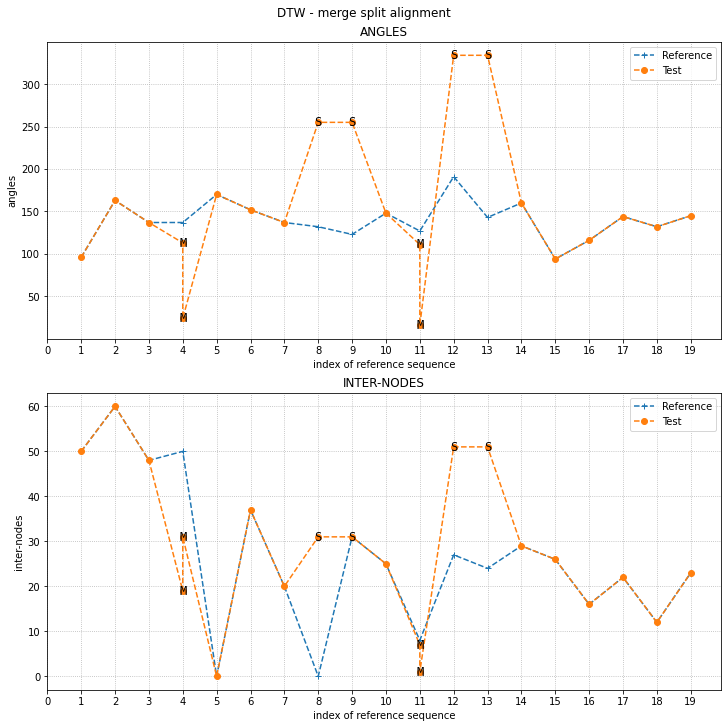

In [9]:
## Test: the function plot_results is working with Jo's example:
seq_test = np.array([[96, 163, 137, 113, 24, 170, 152, 137, 255, 148, 111, 16, 334, 160, 94, 116, 144, 132, 145], [50, 60, 48, 19, 31, 0, 37, 20, 31, 25, 7, 1, 51, 29, 26, 16, 22, 12, 23]]).T
seq_ref = np.array([[96, 163, 137, 137, 170, 152, 137, 132, 123, 148, 127, 191, 143, 160, 94, 116, 144, 132, 145], [50, 60, 48, 50, 0, 37, 20, 0, 31, 25, 8, 27, 24, 29, 26, 16, 22, 12, 23 ]]).T
max_ref = np.max(seq_ref[:, 1])
max_test = np.max(seq_test[:, 1])
dtwcomputer = DTW(seq_test,seq_ref,constraints='merge_split',ldist=mixed_dist,mixed_type=[True, False],mixed_spread=[1, max(max_ref, max_test)],mixed_weight=[0.5, 0.5],names=["angles", "inter-nodes"])
dtwcomputer.run()
dtwcomputer.plot_results()

## Automatic selection of free-ends
Now, we will see how to adjust the size of the possible free-ends: `sm-dtw` will look for possible organ addition/loss at both ends.
However, trimming of sequences is limited to max 40% of the shortest sequence length among the pair to avoid overfitting of extremely short and costless alignment solutions.

In [10]:
# check the previous values of free-ends: default is (0,1) for perfectly matching start and end sequences.
dtwcomputer.free_ends

(0, 1)

In [13]:
#reset free-ends
dtwcomputer.free_ends = (3, 4)
dtwcomputer.run()
dtwcomputer.get_results()
#dtwcomputer.summarize() /!\ not working yet
dtwcomputer.free_ends = (0, 1)

In [14]:
free_ends, n_cost = brute_force_free_ends_search(dtwcomputer)
print(f"Found free-ends {free_ends} with a normalized distance of {n_cost}.")

Found free-ends (0, 1) with a normalized distance of 0.0.
